In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon May 18 17:59:23 2020
@author: rfablet
"""

#######################################

import argparse
import numpy as np
import matplotlib.pyplot as plt 
#import os
#import tensorflow.keras as keras
import xarray as xr

import time
import copy
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import scipy
from scipy.integrate import solve_ivp
from sklearn.feature_extraction import image
from netCDF4 import Dataset
import datetime

# specific torch module 
#import dinAE_solver_torch as dinAE
import torch_4DVarNN_dinAE_Copy1 as NN_4DVar
#import torch4DVarNN_solver as NN_4DVar
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from netCDF4 import Dataset



############################
'''
# !/usr/bin/env python3
# -*- coding: utf-8 -*-
from pathlib import Path

import argparse
import numpy as np
import datetime

import matplotlib.pyplot as plt

import time
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR


import os
import sys
sys.path.append('../4dvarnet-core')
import solver as NN_4DVar

from sklearn.feature_extraction import image

from scipy import ndimage

'''
parser = argparse.ArgumentParser()
flagProcess    = [0,1,2,3,4]#Sequence fo processes to be run
    
flagRandomSeed = 0
flagSaveModel  = 1
     
batch_size  = 96#4#4#8#12#8#256#8 originellement 96

dirSAVE     = './ResDanube4DVar/'
suffix_exp='exp3'
genFilename = 'Debit_v11'
  
flagAEType = 2 # 0: L96 model, 1-2: GENN
DimAE      = 50#50#10#50
    
UsePriodicBoundary = True # use a periodic boundary for all conv operators in the gradient model (see torch_4DVarNN_dinAE)
InterpFlag         = False

NbDays          = 18244

time_step  = 1
DT = 13
sigNoise   = np.sqrt(2)
rateMissingData = 0.5#0.9
width_med_filt_spatial = 5
width_med_filt_temp = 1


# loss weghing wrt time
w_ = np.zeros(DT)
w_[int(DT / 2)] = 1.
wLoss = torch.Tensor(w_)

flagTypeMissData = 4

#####################################



#import torch.distributed as dist

## NN architectures and optimization parameters
#batch_size      = 2#16#4#4#8#12#8#256#
#DimAE           = 50#10#10#50
#dimGradSolver   = 100 # dimension of the hidden state of the LSTM cell
#rateDropout     = 0.25 # dropout rate 
#flag_aug_state = 2#True#
#flag_augment_training_data = True#False#

# data generation
#sigNoise = 0. ## additive noise standard deviation
#flagSWOTData = True #False # rue ## use SWOT data or not
#flagNoSSTObs = False #True #
#flag_vv  = 'vv_10m'

#width_med_filt_spatial = 5
#width_med_filt_temp = 1

#dT              = 5 ## Time window of each space-time patch
#W               = 200 ## width/height of each space-time patch
#dx              = 1 ## subsampling step if > 1
#Nbpatches       = 1#10#10#25 ## number of patches extracted from each time-step 
#rnd1            = 0 ## random seed for patch extraction (space sam)
#rnd2            = 100 ## random seed for patch extraction
#dwscale         = 1

# loss
#p_norm_loss = 2. 
#q_norm_loss = 2. 
#r_norm_loss = 2. 
#thr_norm_loss = 0.

#W = int(W/dx)

#UsePriodicBoundary = False # use a periodic boundary for all conv operators in the gradient model (see torch_4DVarNN_dinAE)
#InterpFlag         = False # True => force reconstructed field to observed data after each gradient-based update

print('........ Data extraction')
if flagRandomSeed == 0:
    print('........ Random seed set to 100')
    np.random.seed(100)
        
###############################################################
## data extraction
ncfile = Dataset('Dataset_danube.nc',"r")
L=[]
for i in range(31):
    L.append(ncfile['S'+str(i+1)][:].reshape(18244,1))
        
dataset = np.concatenate((L[0],L[1],L[2],L[3],L[4],L[5],L[6],L[7],L[8],L[9],L[10],L[11],L[12],L[13],L[14],L[15],L[16],L[17],L[18],L[19],L[20],L[21],L[22],L[23],L[24],L[25],L[26],L[27],L[28],L[29],L[30]),axis=1)

seuil_10 = np.zeros(31)
#for i in range(31) :
#    Si = sorted(L[i],reverse = True)[int(18244/10)]
#    print(Si)
#    seuil_10[i]=Si[0]
seuil_10 =np.array([2220.,  1020. ,  764.,   744. ,  577. ,  535.,   511.,   329.,   279. ,  218.,
   92.3 ,  45.,  1240.,   257. ,  250.,   116. ,   81.5,   46.7,   35.3,  179.,
  130.,   123.,    96.5,   78.6 ,  69.,    62.1,   47.6 ,  81.8,   74.4 , 449.,
  427. ])    
print(seuil_10)


# Definiton of training, validation and test dataset    
i=0
Indtrain=[]
Indval=[]
Indtest=[]
while (i+1)*395<(NbDays-1):
    x=395*i
    Indtrain.append([x,(x+305)])
    Indval.append([(x+319),(x+350)])
    Indtest.append([x+364,x+395])
    i+=1
    

#Se restreindre à l'été car pas de pluie??
day0=datetime.date(1960,1,1)
dayend=datetime.date(2009,12,12)


#Trouver une valeur de seuil pour étudier le coût KL au-dessus du seuil : on se place dans flagTypeProcess 3 avec la station 4 masquée

D=dataset[Indtrain[0][0]:Indtrain[0][1],3]
for k in Indtrain[1::]:
    D=np.concatenate((D,dataset[k[0]:k[1],3]),axis=0)
r=0.1 #fraction supérieure 
D.sort()
seuil=D[int((1-r)*len(D))]



"""


# Definiton of training, validation and test dataset
# from dayly indices over a one-year time series

suffix_exp = "exp2"
day_0 = datetime.date(2012,10,1)

if suffix_exp == "exp3" :
    iiVal = 60 - int(dT / 2)
    jjVal = iiVal + 20 + int(dT / 2) #int(dT / 2)
    
    iiTest = jjVal + 10 #90 - int(dT / 2)
    jjTest = iiTest + 20 + 2*int(dT / 2) # 110 + int(dT / 2)
     
    iiTr1 = 0
    jjTr1 = iiVal - 10 #50 - int(dT / 2)
    
    iiTr2 = jjTest + 10 #130 + int(dT / 2)
    jjTr2 = 365
elif suffix_exp == "exp2" :
    day_val  = datetime.date(2013,1,1)
    iiVal = int((day_val - day_0).days)
    jjVal = iiVal + 20 + 2*int(dT / 2) #int(dT / 2)
    
    day_test_0  = datetime.date(2012,10,22)
    day_test_1  = datetime.date(2012,12,2)
    iiTest = int((day_test_0 - day_0).days) - int(dT / 2) #90 - int(dT / 2)
    jjTest = int((day_test_1 - day_0).days) + int(dT / 2) # 110 + int(dT / 2)
     
    iiTr1 = jjVal + 10
    jjTr1 = 365
    
    iiTr2 = 365 #130 + int(dT / 2)
    jjTr2 = 365
elif suffix_exp == "summer" : # Summer
    day_val  = datetime.date(2013,7,1)
    iiVal = int((day_val - day_0).days)
    jjVal = iiVal + 20 + 2*int(dT / 2) #int(dT / 2)
    
    iiTest = jjVal + 10 #90 - int(dT / 2)
    jjTest = iiTest + 20 + 2*int(dT / 2) # 110 + int(dT / 2)
     
    iiTr1 = 0
    jjTr1 = iiVal - 10 #50 - int(dT / 2)
    
    iiTr2 = jjTest + 10 #130 + int(dT / 2)
    jjTr2 = 365
elif suffix_exp == "spring" : # Spring
    day_val  = datetime.date(2013,4,1)
    iiVal = int((day_val - day_0).days)
    jjVal = iiVal + 20 + 2*int(dT / 2) #int(dT / 2)
    
    iiTest = jjVal + 10 #90 - int(dT / 2)
    jjTest = iiTest + 20 + 2*int(dT / 2) # 110 + int(dT / 2)
     
    iiTr1 = 0
    jjTr1 = iiVal - 10 #50 - int(dT / 2)
    
    iiTr2 = jjTest + 10 #130 + int(dT / 2)
    jjTr2 = 365
elif suffix_exp == "winter" : # Winter
    day_val  = datetime.date(2013,1,1)
    iiVal = int((day_val - day_0).days)
    jjVal = iiVal + 20 + 2*int(dT / 2) #int(dT / 2)
    
    iiTest = jjVal + 10 #90 - int(dT / 2)
    jjTest = iiTest + 20 + 2*int(dT / 2) # 110 + int(dT / 2)
     
    iiTr1 = 0
    jjTr1 = iiVal - 10 #50 - int(dT / 2)
    
    iiTr2 = jjTest + 10 #130 + int(dT / 2)
    jjTr2 = 365
elif suffix_exp == "fall" : # Fall
    day_val  = datetime.date(2012,10,1)
    iiVal = int((day_val - day_0).days)
    jjVal = iiVal + 20 + 2*int(dT / 2) #int(dT / 2)
    
    iiTest = jjVal + 10 #90 - int(dT / 2)
    jjTest = iiTest + 20 + 2*int(dT / 2) # 110 + int(dT / 2)
     
    iiTr1 = 0
    jjTr1 = iiVal - 10 #50 - int(dT / 2)
    
    iiTr2 = jjTest + 10 #130 + int(dT / 2)
    jjTr2 = 365
elif suffix_exp == "winter2" : # Winter
    day_val  = datetime.date(2013,1,1)
    iiVal = int((day_val - day_0).days)
    jjVal = iiVal + 20 + 2*int(dT / 2) #int(dT / 2)
    
    iiTest = jjVal + 30 #90 - int(dT / 2)
    jjTest = iiTest + 20 + 2*int(dT / 2) # 110 + int(dT / 2)
     
    iiTr1 = 0
    jjTr1 = iiVal - 10 #50 - int(dT / 2)
    
    iiTr2 = jjTest + 30 #130 + int(dT / 2)
    jjTr2 = 365
elif suffix_exp == "spring2" : # Spring
    day_val  = datetime.date(2013,4,1)
    iiVal = int((day_val - day_0).days)
    jjVal = iiVal + 20 + 2*int(dT / 2) #int(dT / 2)
    
    iiTest = jjVal + 30 #90 - int(dT / 2)
    jjTest = iiTest + 20 + 2*int(dT / 2) # 110 + int(dT / 2)
     
    iiTr1 = 0
    jjTr1 = iiVal - 10 #50 - int(dT / 2)
    
    iiTr2 = jjTest + 30 #130 + int(dT / 2)
    jjTr2 = 365
"""

    
    ####################################################
## Generation of training  validationand test dataset
## Extraction of time series of dT time steps
#NbTraining = 6000#2000
#NbTest     = 256#256#500
#NbVal = ?
    
dataTrainingNoNaND = image.extract_patches_2d(dataset[Indtrain[0][0]:Indtrain[0][1],:],(DT,31)) 
for k in Indtrain[1::]:
    d= image.extract_patches_2d(dataset[k[0]:k[1],:],(DT,31))
    dataTrainingNoNaND=np.concatenate((dataTrainingNoNaND,d),axis=0)
        
    
dataValNoNaND = image.extract_patches_2d(dataset[Indval[0][0]:Indval[0][1],:],(DT,31))    
for k in Indval[1::]:
    d= image.extract_patches_2d(dataset[k[0]:k[1],:],(DT,31))
    dataValNoNaND=np.concatenate((dataValNoNaND,d),axis=0)
print(dataValNoNaND.shape )  
    
dataTestNoNaND = image.extract_patches_2d(dataset[Indtest[0][0]:Indtest[0][1],:],(DT,31))
for k in Indtest[1::]:
    d= image.extract_patches_2d(dataset[k[0]:k[1],:],(DT,31))
    dataTestNoNaND=np.concatenate((dataTestNoNaND,d),axis=0)
print(dataTestNoNaND.shape ) 
        
# create missing data
#flagTypeMissData = 0 : Missing data randomly chosen on the patch driven by rateMissingData
#flagTypeMissData = 1 : Almost the same
#flagTypeMissData = 2 : In each patch, different station are randomly chosen and are masked according to rateMissingData
#flagTypeMissData = 3 : The same stations listed in MaskedStations are masked
#flagTpeMissData = 4  : Prevision

if flagTypeMissData == 0:
    indRandD         = np.random.permutation(dataTrainingNoNaND.shape[0]*dataTrainingNoNaND.shape[1]*dataTrainingNoNaND.shape[2])
    indRandD         = indRandD[0:int(rateMissingData*len(indRandD))]
    dataTrainingD    = np.copy(dataTrainingNoNaND).reshape((dataTrainingNoNaND.shape[0]*dataTrainingNoNaND.shape[1]*dataTrainingNoNaND.shape[2],1))
    dataTrainingD[indRandD] = float('nan')
    dataTrainingD    = np.reshape(dataTrainingD,(dataTrainingNoNaND.shape[0],dataTrainingNoNaND.shape[1],dataTrainingNoNaND.shape[2]))
            
    indRandD         = np.random.permutation(dataValNoNaND.shape[0]*dataValNoNaND.shape[1]*dataValNoNaND.shape[2])
    indRandD         = indRandD[0:int(rateMissingData*len(indRandD))]
    dataValD    = np.copy(dataValNoNaND).reshape((dataValNoNaND.shape[0]*dataValNoNaND.shape[1]*dataValNoNaND.shape[2],1))
    dataValD[indRandD] = float('nan')
    dataValD    = np.reshape(dataValD,(dataValNoNaND.shape[0],dataValNoNaND.shape[1],dataValNoNaND.shape[2]))
            
            
    indRandD         = np.random.permutation(dataTestNoNaND.shape[0]*dataTestNoNaND.shape[1]*dataTestNoNaND.shape[2])
    indRandD         = indRandD[0:int(rateMissingData*len(indRandD))]
    dataTestD        = np.copy(dataTestNoNaND).reshape((dataTestNoNaND.shape[0]*dataTestNoNaND.shape[1]*dataTestNoNaND.shape[2],1))
    dataTestD[indRandD] = float('nan')
    dataTestD          = np.reshape(dataTestD,(dataTestNoNaND.shape[0],dataTestNoNaND.shape[1],dataTestNoNaND.shape[2]))

    genSuffixObs    = '_ObsRnd_%02d_%02d'%(100*rateMissingData,10*sigNoise**2)
        
elif flagTypeMissData==1:
    time_step_obs   = int(1./(1.-rateMissingData))
    dataTrainingD    = np.zeros((dataTrainingNoNaND.shape))
    dataTrainingD[:] = float('nan')
            
    dataValD    = np.zeros((dataValNoNaND.shape))
    dataValD[:] = float('nan')
            
    dataTestD        = np.zeros((dataTestNoNaND.shape))
    dataTestD[:]     = float('nan')
               
    if 1*0:
                
        dataTrainingD[:,::time_step_obs,:] = dataTrainingNoNaND[:,::time_step_obs,:]
        dataValD[:,::time_step_obs,:] = dataValNoNaND[:,::time_step_obs,:]
        dataTestD[:,::time_step_obs,:]     = dataTestNoNaND[:,::time_step_obs,:]
                    
        genSuffixObs    = '_ObsSub_%02d_%02d'%(100*rateMissingData,10*sigNoise**2)
    else:
        for nn in range(0,dataTrainingD.shape[1],time_step_obs):
            indrand = np.random.permutation(dataTrainingD.shape[2])[0:int(0.5*dataTrainingD.shape[1])]
            dataTrainingD[:,nn,indrand] = dataTrainingNoNaND[:,nn,indrand]
                    
        for nn in range(0,dataTrainingD.shape[1],time_step_obs):
            indrand = np.random.permutation(dataTrainingD.shape[2])[0:int(0.5*dataTrainingD.shape[1])]
            dataValD[:,nn,indrand] = dataValNoNaND[:,nn,indrand]
                    
        for nn in range(0,dataTrainingD.shape[1],time_step_obs):
            indrand = np.random.permutation(dataTrainingD.shape[2])[0:int(0.5*dataTrainingD.shape[1])]
            dataTestD[:,nn,indrand] = dataTestNoNaND[:,nn,indrand]

        genSuffixObs    = '_ObsSubRnd_%02d_%02d'%(100*rateMissingData,10*sigNoise**2)
        
elif flagTypeMissData == 2 :
    #
    Nbtraining=13110
    Nbval=506
    Nbtest=506
            
    ratemissingdata_space = 0.15
    time_step_obs   = int(1./(1.-rateMissingData))
    dataTrainingD    = np.zeros(([Nbtraining,dataTrainingNoNaND.shape[1],dataTrainingNoNaND.shape[2]]))
    dataTrainingD[:] = float('nan')
    dataTrainingNoNaND2    = np.zeros(([Nbtraining,dataTrainingNoNaND.shape[1],dataTrainingNoNaND.shape[2]]))
    dataTrainingNoNaND2[:] = float('nan')
            
    dataValD    = np.zeros(([Nbval,dataTrainingNoNaND.shape[1],dataTrainingNoNaND.shape[2]]))           
    dataValD[:] = float('nan')
    dataValNoNaND2=np.zeros(([Nbval,dataTrainingNoNaND.shape[1],dataTrainingNoNaND.shape[2]]))
    dataValNoNaND2[:] = float('nan')
            
    dataTestD        = np.zeros(([Nbtest,dataTrainingNoNaND.shape[1],dataTrainingNoNaND.shape[2]]))
    dataTestD[:]     = float('nan') 
    dataTestNoNaND2 =np.zeros(([Nbtest,dataTrainingNoNaND.shape[1],dataTrainingNoNaND.shape[2]]))
    dataTestNoNaND2[:] = float('nan')
            
    ind=0
    print(dataTrainingD.shape)
    
    while ind<Nbtraining:
        indrand=np.random.permutation(dataTrainingD.shape[2])[0:int((1-ratemissingdata_space)*dataTrainingD.shape[2])]
        dataTrainingD[ind,:,indrand]=dataTrainingNoNaND[ind%dataTrainingNoNaND.shape[0],:,indrand]
        dataTrainingNoNaND2[ind,:,:]=dataTrainingNoNaND[ind%dataTrainingNoNaND.shape[0],:,:]
                
        if ind <Nbval:
            indrand2=np.random.permutation(dataTrainingD.shape[2])[0:int((1-ratemissingdata_space)*dataTrainingD.shape[2])]
            dataValD[ind,:,indrand2]=dataValNoNaND[ind%dataValNoNaND.shape[0],:,indrand2]
            dataValNoNaND2[ind,:,:]=dataValNoNaND[ind%dataValNoNaND.shape[0],:,:]
                
            indrand3=np.random.permutation(dataTrainingD.shape[2])[0:int((1-ratemissingdata_space)*dataTrainingD.shape[2])]
            dataTestD[ind,:,indrand3]=dataTestNoNaND[ind%dataTestNoNaND.shape[0],:,indrand3]
            dataTestNoNaND2[ind,:,:] = dataTestNoNaND[ind%dataTestNoNaND.shape[0],:,:]
        ind+=1
                
    dataTrainingNoNaND =dataTrainingNoNaND2
    dataValNoNaND = dataValNoNaND2
    dataTestNoNaND =dataTestNoNaND2        
    genSuffixObs    = '_ObsSubRnd_%02d_%02d'%(100*rateMissingData,10*sigNoise**2) 
        
#mask only on specific station
elif flagTypeMissData == 3 :
    MaskedStations=[2,4,16,25]
            
    dataTrainingD    = np.zeros((dataTrainingNoNaND.shape))
    dataTrainingD[:] = float('nan')
            
    dataValD    = np.zeros((dataValNoNaND.shape))
    dataValD[:] = float('nan')
            
    dataTestD        = np.zeros((dataTestNoNaND.shape))
    dataTestD[:]     = float('nan')
    print(dataTrainingNoNaND[0,:,:])  
    for i in range(31):
        dataTrainingD[:,:,i] = dataTrainingNoNaND[:,:,i]
        dataValD[:,:,i] = dataValNoNaND[:,:,i]
        dataTestD[:,:,i] = dataTestNoNaND[:,:,i]
    for i in MaskedStations:
        dataTrainingD[:,:,i-1] = float('nan')
        dataValD[:,:,i-1] = float('nan')
        dataTestD[:,:,i-1] = float('nan')
    genSuffixObs    = '_ObsSubRnd_%02d_%02d'%(100*rateMissingData,10*sigNoise**2)
    print(dataTrainingNoNaND[0,:,:])
    
else : 
    dataTrainingD    = np.zeros((dataTrainingNoNaND.shape))
    dataTrainingD[:] = float('nan')
            
    dataValD    = np.zeros((dataValNoNaND.shape))
    dataValD[:] = float('nan')
            
    dataTestD        = np.zeros((dataTestNoNaND.shape))
    dataTestD[:]     = float('nan')
    
    dataTrainingD[:,:(int(2*DT/3+1)),:] = dataTrainingNoNaND[:,:(int(2*DT/3+1)),:]
    dataValD[:,:(int(2*DT/3+1)),:] = dataValNoNaND[:,:(int(2*DT/3+1)),:]
    dataTestD[:,:(int(2*DT/3+1)),:] = dataTestNoNaND[:,:(int(2*DT/3+1)),:]
    genSuffixObs    = '_ObsSubRnd_%02d_%02d'%(100*rateMissingData,10*sigNoise**2)
    
print('... Data type: '+genSuffixObs)
    #for nn in range(0,dataTraining.shape[1],time_step_obs):
    #    dataTraining[:,::time_step_obs,:] = dataTrainingNoNaN[:,::time_step_obs,:]
    #dataTest    = np.zeros((dataTestNoNaN.shape))
    #dataTest[:] = float('nan')
    #dataTest[:,::time_step_obs,:] = dataTestNoNaN[:,::time_step_obs,:]
        
# set to NaN patch boundaries    
if 1*0:
    dataTrainingD[:,0:10,:] =  float('nan')
    dataValD[:,0:10,:] =  float('nan')
    dataTestD[:,0:10,:]     =  float('nan')
    dataTrainingD[:,dT-10:dT,:] =  float('nan')
    dataValD[:,dT-10:dT,:] =  float('nan')
    dataTestD[:,dT-10:dT,:]     =  float('nan')
            
                                
# mask for NaN
maskTrainingD = (dataTrainingD == dataTrainingD).astype('float')
maskValD = (dataValD == dataValD).astype('float')
maskTestD     = ( dataTestD    ==  dataTestD   ).astype('float')
            
dataTrainingD = np.nan_to_num(dataTrainingD)
        
dataValD = np.nan_to_num(dataValD)
dataTestD     = np.nan_to_num(dataTestD)
            
    # Permutation to have channel as #1 component
dataTrainingD      = np.moveaxis(dataTrainingD,-1,1)
maskTrainingD      = np.moveaxis(maskTrainingD,-1,1)
dataTrainingNoNaND = np.moveaxis(dataTrainingNoNaND,-1,1)
        
dataValD      = np.moveaxis(dataValD,-1,1)
maskValD      = np.moveaxis(maskValD,-1,1)
dataValNoNaND = np.moveaxis(dataValNoNaND,-1,1)
            
dataTestD      = np.moveaxis(dataTestD,-1,1)
maskTestD      = np.moveaxis(maskTestD,-1,1)
dataTestNoNaND = np.moveaxis(dataTestNoNaND,-1,1)
            
# set to NaN patch boundaries
#dataTraining[:,0:5,:] =  dataTrainingNoNaN[:,0:5,:]
#dataTest[:,0:5,:]     =  dataTestNoNaN[:,0:5,:]
    
############################################
## raw data
X_trainD         = dataTrainingNoNaND
        
X_train_missingD = dataTrainingD
mask_trainD      = maskTrainingD
        
X_valD         = dataValNoNaND
X_val_missingD = dataValD
mask_valD      = maskValD
        
X_testD         = dataTestNoNaND
X_test_missingD = dataTestD
mask_testD      = maskTestD
            
############################################
## normalized data wrt to each measurement station
        
if flagTypeMissData ==2 :
    mean2 = np.mean(X_train_missingD[:],0)
    mean2mask = np.mean(mask_trainD[:],0)


    mean3 = np.mean(mean2,1)
    mean3 = mean3.reshape(31,1)
    print(mean3)
    mean3mask = np.mean(mean2mask,1)
    mean3mask = mean3mask.reshape(31,1)
    print(mean3mask)
    meanTr          = mean3/mean3mask
    print(meanTr)
    mean2true = np.mean(X_trainD[:],0)
    mean3true = np.mean(mean2true,1)
    mean3true = mean3true.reshape(31,1)
    meanTrtrue = mean3true
    print(meanTrtrue)
            
    meansquaretrue = np.mean( (X_trainD-meanTrtrue)**2,0)
    meansquare2true = np.mean(meansquaretrue,1)
    meansquare2true=meansquare2true.reshape(31,1)
    stdTrtrue           = np.sqrt(meansquare2true )
    print(stdTrtrue)
            
            
    x_train_missingD = X_train_missingD - meanTr*mask_trainD
            
    x_val_missingD = X_val_missingD - meanTr*mask_valD
    x_test_missingD  = X_test_missingD - meanTr*mask_testD
            
    # scale wrt to each station
    meansquare = np.mean( X_train_missingD**2,0)
    meansquare2 = np.mean(meansquare,1)
    meansquare2=meansquare2.reshape(31,1)
    stdTr           = np.sqrt(meansquare2 / mean3mask)
            
    x_train_missingD = x_train_missingD / stdTr
    x_val_missingD = x_val_missingD / stdTr
    x_test_missingD  = x_test_missingD / stdTr
            
    x_trainD = (X_trainD - meanTr) / stdTr
    x_valD = (X_valD - meanTr) / stdTr
    x_testD  = (X_testD - meanTr) / stdTr
            
    print(np.mean(x_train_missingD))
    print(np.mean(x_trainD))
    print(np.mean(x_val_missingD))
    print(np.mean(x_valD))
    print(np.mean(x_test_missingD))
    print(np.mean(x_testD))
            
            
               
elif flagTypeMissData==3 :
    mean2 = np.mean(X_train_missingD[:],0)
    mean3 = np.mean(mean2,1)
    mean3 = mean3.reshape(31,1)
    meanTr = mean3
    x_train_missingD = X_train_missingD - meanTr
    x_val_missingD = X_val_missingD - meanTr
    x_test_missingD  = X_test_missingD - meanTr
    meansquare = np.mean( x_train_missingD**2,0)
    meansquare2 = np.mean(meansquare,1)
    meansquare2=meansquare2.reshape(31,1)
            
    stdTr           = np.sqrt(meansquare2)
            
    for i in MaskedStations :
        stdTr[i-1] =1
    print(stdTr)
    print(X_trainD[0,:,:])
    x_train_missingD = x_train_missingD / stdTr
    x_val_missingD = x_val_missingD / stdTr
    x_test_missingD  = x_test_missingD / stdTr
    mean2true = np.mean(X_trainD[:],0)
    mean3true = np.mean(mean2true,1)
    mean3true = mean3true.reshape(31,1)
    meanTrtrue = mean3true
            
    meansquaretrue = np.mean( (X_trainD-meanTrtrue)**2,0)
    meansquare2true = np.mean(meansquaretrue,1)
    meansquare2true=meansquare2true.reshape(31,1)
    stdTrtrue           = np.sqrt(meansquare2true )
    print(stdTrtrue)
    print(meanTrtrue)
            
    x_trainD = (X_trainD - meanTrtrue) / stdTrtrue
    x_valD = (X_valD - meanTrtrue) / stdTrtrue
    x_testD  = (X_testD - meanTrtrue) / stdTrtrue
            
elif flagTypeMissData == 4 :
    #Moyenne des débits par station sur l'échatillon total
    M = np.mean(X_trainD,0)
    mean_X_trainD = np.mean(M,1)
    mean_X_trainD = mean_X_trainD.reshape(31,1)
    meanTr        = mean_X_trainD
    meanTrtrue = meanTr
    #Moyenne des débits
    X_nomask=X_trainD[:,:,:(int(2*DT/3+1))]
    M2 = np.mean(X_nomask,0)
    mean_X_train_missingD = np.mean(M2,1)
    mean_X_train_missingD = mean_X_train_missingD.reshape(31,1)

    #Ecart-type:
    meansquaretrue = np.mean( (X_trainD-mean_X_trainD)**2,0)
    meansquare2true = np.mean(meansquaretrue,1)
    meansquare2true=meansquare2true.reshape(31,1)
    stdTrtrue           = np.sqrt(meansquare2true )
    
    #Normalisation et standardisation des données
    x_train_missingD = np.zeros(X_train_missingD.shape)
    x_train_missingD[:,:,:(int(2*DT/3)+1)]=(X_train_missingD[:,:,:(int(2*DT/3)+1)]-mean_X_trainD)/stdTrtrue
 
    x_val_missingD = np.zeros(X_val_missingD.shape)
    x_val_missingD[:,:,:(int(2*DT/3)+1)]=(X_val_missingD[:,:,:(int(2*DT/3)+1)]-mean_X_trainD)/stdTrtrue

    x_test_missingD = np.zeros(X_test_missingD.shape)
    x_test_missingD[:,:,:(int(2*DT/3)+1)]=(X_test_missingD[:,:,:(int(2*DT/3)+1)]-mean_X_trainD)/stdTrtrue


    x_trainD = (X_trainD - mean_X_trainD) / stdTrtrue
    x_valD = (X_valD - mean_X_trainD) / stdTrtrue
    x_testD  = (X_testD - mean_X_trainD) / stdTrtrue
    
    stdTr =stdTrtrue
    
else : 
    mean2 = np.mean(X_train_missingD[:],0)
    mean2mask = np.mean(mask_trainD[:],0)
            

    mean3 = np.mean(mean2,1)
    mean3 = mean3.reshape(31,1)
    print(mean3)
    mean3mask = np.mean(mean2mask,1)
    mean3mask = mean3mask.reshape(31,1)
    print(mean3mask)
    meanTr          = mean3/mean3mask
    print(meanTr)
            
    x_train_missingD = X_train_missingD - meanTr*mask_trainD
    x_val_missingD = X_val_missingD - meanTr
    x_test_missingD  = X_test_missingD - meanTr
            
    # scale wrt to each station
    meansquare = np.mean( X_train_missingD**2,0)
    meansquare2 = np.mean(meansquare,1)
    meansquare2=meansquare2.reshape(31,1)
    stdTr           = np.sqrt(meansquare2 / mean3mask)
            
    x_train_missingD = x_train_missingD / stdTr
    x_val_missingD = x_val_missingD / stdTr
    x_test_missingD  = x_test_missingD / stdTr
            
    x_trainD = (X_trainD - meanTr) / stdTr
    x_valD = (X_valD - meanTr) / stdTr
    x_testD  = (X_testD - meanTr) / stdTr
            
# Generate noisy observsation
        
#X_train_obsD = X_train_missingD + sigNoise * maskTrainingD * np.random.randn(X_train_missingD.shape[0],X_train_missingD.shape[1],X_train_missingD.shape[2])
#X_val_obsD = X_val_missingD + sigNoise * maskValD * np.random.randn(X_val_missingD.shape[0],X_val_missingD.shape[1],X_val_missingD.shape[2])
#X_test_obsD  = X_test_missingD  + sigNoise * maskTestD * np.random.randn(X_test_missingD.shape[0],X_test_missingD.shape[1],X_test_missingD.shape[2])
            
#x_train_obsD = (X_train_obsD - meanTr) / stdTr
#x_val_obsD = (X_val_obsD - meanTr) / stdTr
#x_test_obsD  = (X_test_obsD - meanTr) / stdTr
        
#Without noise :
X_train_obsD = X_train_missingD 
X_val_obsD = X_val_missingD 
X_test_obsD  = X_test_missingD
        
x_train_obsD = x_train_missingD
x_val_obsD = x_val_missingD
x_test_obsD = x_test_missingD 

m_seuil = ((seuil_10.reshape(31,1)-meanTr)/stdTr)
print(seuil_10.shape)
print(meanTr.shape)
print(stdTr.shape)
print("seuil normalisé")
print(m_seuil)
        
print('..... Training dataset: %dx%dx%d'%(x_train_missingD.shape[0],x_trainD.shape[1],x_trainD.shape[2]))
print('..... Validation dataset: %dx%dx%d'%(x_valD.shape[0],x_valD.shape[1],x_valD.shape[2]))
print('..... Test dataset    : %dx%dx%d'%(x_testD.shape[0],x_testD.shape[1],x_testD.shape[2]))
            

print('........ Initialize interpolated states')


........ Data extraction
........ Random seed set to 100
[2220.  1020.   764.   744.   577.   535.   511.   329.   279.   218.
   92.3   45.  1240.   257.   250.   116.    81.5   46.7   35.3  179.
  130.   123.    96.5   78.6   69.    62.1   47.6   81.8   74.4  449.
  427. ]
(874, 13, 31)
(874, 13, 31)
... Data type: _ObsSubRnd_50_20
(31,)
(31, 1)
(31, 1)
seuil normalisé
[[1.31824764]
 [1.26866338]
 [1.25838101]
 [1.25653513]
 [1.21610044]
 [1.20150933]
 [1.2163678 ]
 [1.19586817]
 [1.22944378]
 [1.24693638]
 [1.17121264]
 [1.26490812]
 [1.30504977]
 [1.24744332]
 [1.32544306]
 [1.09160007]
 [1.1116852 ]
 [0.87639607]
 [0.76977733]
 [1.07203351]
 [1.04262843]
 [1.14722608]
 [1.15214541]
 [1.14882606]
 [1.05608624]
 [1.03135639]
 [1.07488227]
 [1.21720527]
 [1.19016786]
 [1.21929718]
 [1.25150911]]
..... Training dataset: 13478x31x13
..... Validation dataset: 874x31x13
..... Test dataset    : 874x31x13
........ Initialize interpolated states


In [17]:
## Initial interpolation
#flagInit = 0 : Masked values are replaced by 0
#flagInit = 1 : masked values are replaced by last available value (prevision)
#flaginit = 2 : Interpolation 

flagInit = 1
print(X_train_missingD[0,:,:])
            
if flagInit == 0: 
    X_train_InitD = mask_trainD * X_train_obsD + (1. - mask_trainD) * (np.zeros(X_train_missingD.shape) + meanTr)
    X_val_InitD = mask_valD * X_val_obsD + (1. - mask_valD) * (np.zeros(X_val_missingD.shape) + meanTr)
    X_test_InitD  = mask_testD * X_test_obsD + (1. - mask_testD) * (np.zeros(X_test_missingD.shape) + meanTr)
    
elif flagInit==1 :
    X_ext_train = X_train_missingD[:,:,int(2*DT/3)].reshape(X_train_missingD.shape[0],X_train_missingD.shape[1],1)
    X_train_InitD = mask_trainD * X_train_obsD + (1. - mask_trainD)*X_ext_train
    X_ext_val = X_val_missingD[:,:,int(2*DT/3)].reshape(X_val_missingD.shape[0],X_val_missingD.shape[1],1)
    X_train_InitD = mask_valD * X_val_obsD + (1. - mask_valD)*X_ext_val
    X_ext_test = X_test_missingD[:,:,int(2*DT/3)].reshape(X_test_missingD.shape[0],X_test_missingD.shape[1],1)
    X_testInitD = mask_testD * X_test_obsD + (1. - mask_testD)*X_ext_test
    
    

[[ 951.    916.    896.    955.    967.    983.   1040.   1010.   1030.
     0.      0.      0.      0.  ]
 [ 524.    543.    513.    510.    513.    581.    597.    581.    589.
     0.      0.      0.      0.  ]
 [ 417.    425.    396.    384.    388.    458.    447.    430.    441.
     0.      0.      0.      0.  ]
 [ 419.    385.    366.    352.    419.    437.    400.    406.    417.
     0.      0.      0.      0.  ]
 [ 314.    282.    272.    258.    328.    335.    297.    305.    299.
     0.      0.      0.      0.  ]
 [ 288.    260.    247.    237.    310.    308.    277.    282.    273.
     0.      0.      0.      0.  ]
 [ 248.    236.    231.    238.    321.    306.    269.    252.    245.
     0.      0.      0.      0.  ]
 [ 200.    181.    163.    182.    227.    204.    193.    190.    178.
     0.      0.      0.      0.  ]
 [ 168.    155.    129.    181.    205.    167.    162.    155.    142.
     0.      0.      0.      0.  ]
 [ 135.    125.    106.    170.    16

In [9]:
                                
# mask for NaN
maskTrainingD = (dataTrainingD == dataTrainingD).astype('float')
maskValD = (dataValD == dataValD).astype('float')
maskTestD     = ( dataTestD    ==  dataTestD   ).astype('float')
print(maskTrainingD[0,:,:])
            
dataTrainingD = np.nan_to_num(dataTrainingD)       
dataValD = np.nan_to_num(dataValD)
dataTestD     = np.nan_to_num(dataTestD)
print(dataTrainingD[0,:,:])
print(dataTrainingD.shape)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0.

In [4]:
            
    # Permutation to have channel as #1 component
dataTrainingD      = np.moveaxis(dataTrainingD,-1,1)
maskTrainingD      = np.moveaxis(maskTrainingD,-1,1)
dataTrainingNoNaND = np.moveaxis(dataTrainingNoNaND,-1,1)
print(dataTrainingD.shape)
        
dataValD      = np.moveaxis(dataValD,-1,1)
maskValD      = np.moveaxis(maskValD,-1,1)
dataValNoNaND = np.moveaxis(dataValNoNaND,-1,1)
            
dataTestD      = np.moveaxis(dataTestD,-1,1)
maskTestD      = np.moveaxis(maskTestD,-1,1)
dataTestNoNaND = np.moveaxis(dataTestNoNaND,-1,1)

(13110, 31, 21)


In [10]:
    
############################################
## raw data
X_trainD         = dataTrainingNoNaND
print(X_trainD[0,:,:]) 

X_train_missingD = dataTrainingD
mask_trainD      = maskTrainingD
        
X_valD         = dataValNoNaND
X_val_missingD = dataValD
mask_valD      = maskValD
        
X_testD         = dataTestNoNaND
X_test_missingD = dataTestD
mask_testD      = maskTestD

[[ 951.    916.    896.    955.    967.    983.   1040.   1010.   1030.
   979.    885.    799.    775.    719.    719.    698.    664.    639.
   658.    695.    680.  ]
 [ 524.    543.    513.    510.    513.    581.    597.    581.    589.
   581.    535.    471.    428.    404.    385.    370.    364.    361.
   358.    382.    379.  ]
 [ 417.    425.    396.    384.    388.    458.    447.    430.    441.
   439.    394.    329.    308.    287.    259.    251.    249.    247.
   249.    278.    274.  ]
 [ 419.    385.    366.    352.    419.    437.    400.    406.    417.
   402.    324.    294.    280.    265.    245.    242.    240.    238.
   245.    260.    264.  ]
 [ 314.    282.    272.    258.    328.    335.    297.    305.    299.
   288.    249.    235.    218.    214.    211.    211.    204.    186.
   195.    193.    191.  ]
 [ 288.    260.    247.    237.    310.    308.    277.    282.    273.
   260.    220.    214.    197.    191.    195.    198.    195.    181.
 

In [15]:
M = np.mean(X_trainD,0)
mean_X_trainD = np.mean(M,1)
mean_X_trainD = mean_X_trainD.reshape(31,1)
print(mean_X_trainD)
X_nomask=X_trainD[:,:,:(int(DT/2+1))]
M2 = np.mean(X_nomask,0)
mean_X_train_missingD = np.mean(M2,1)
mean_X_train_missingD = mean_X_train_missingD.reshape(31,1)
print(X_train_missingD[0,:,:])
print(mean_X_train_missingD)

[[1408.37557662]
 [ 636.36608914]
 [ 459.14530892]
 [ 447.40899277]
 [ 355.3643184 ]
 [ 333.40624605]
 [ 313.73274018]
 [ 194.55132614]
 [ 164.09714031]
 [ 123.86010497]
 [  45.9025836 ]
 [  20.95774233]
 [ 732.38325524]
 [ 171.11155352]
 [ 159.6648647 ]
 [  62.17256678]
 [  47.17658458]
 [  27.01952079]
 [  19.73095558]
 [ 112.2873183 ]
 [  78.91576623]
 [  69.71982834]
 [  49.63537213]
 [  37.71062816]
 [  37.23651324]
 [  33.88651226]
 [  25.67607254]
 [  41.12310799]
 [  36.89404551]
 [ 251.04848534]
 [ 236.36415386]]
[[ 951.   916.   896.   955.   967.   983.  1040.  1010.  1030.   979.
   885.   799.   775.   719.   719.   698.   664.   639.   658.   695.
   680. ]
 [ 524.   543.   513.   510.   513.   581.   597.   581.   589.   581.
   535.   471.   428.   404.   385.   370.   364.   361.   358.   382.
   379. ]
 [ 417.   425.   396.   384.   388.   458.   447.   430.   441.   439.
   394.   329.   308.   287.   259.   251.   249.   247.   249.   278.
   274. ]
 [ 419.   385.  

In [16]:
meansquaretrue = np.mean( (X_trainD-mean_X_trainD)**2,0)
meansquare2true = np.mean(meansquaretrue,1)
meansquare2true=meansquare2true.reshape(31,1)
stdTrtrue           = np.sqrt(meansquare2true )
print(stdTrtrue)

[[612.39963356]
 [301.53800676]
 [241.94437468]
 [235.74525246]
 [181.97537275]
 [167.4923211 ]
 [161.85841078]
 [112.3070918 ]
 [ 93.3841133 ]
 [ 75.37628723]
 [ 39.46083081]
 [ 18.93179983]
 [387.78114172]
 [ 68.23159229]
 [ 67.52888901]
 [ 49.0323657 ]
 [ 30.61545913]
 [ 22.18802769]
 [ 20.00366379]
 [ 61.98118642]
 [ 48.83232821]
 [ 46.25917901]
 [ 40.72237208]
 [ 35.63603417]
 [ 29.91950783]
 [ 27.20402553]
 [ 20.27271707]
 [ 33.27746701]
 [ 31.37399001]
 [161.98665692]
 [152.0257904 ]]


In [17]:
x_train_missingD = np.zeros(X_train_missingD.shape)
print(X_train_missingD[0,:,:])
x_train_missingD[:,:,:(int(DT/2)+1)]=(X_train_missingD[:,:,:(int(DT/2)+1)]-mean_X_trainD)/stdTrtrue
print(x_train_missingD[0,:,:])
x_val_missingD = np.zeros(X_val_missingD.shape)
x_val_missingD[:,:,:(int(DT/2)+1)]=(X_val_missingD[:,:,:(int(DT/2)+1)]-mean_X_trainD)/stdTrtrue

x_test_missingD = np.zeros(X_test_missingD.shape)
x_test_missingD[:,:,:(int(DT/2)+1)]=(X_test_missingD[:,:,:(int(DT/2)+1)]-mean_X_trainD)/stdTrtrue


x_trainD = (X_trainD - mean_X_trainD) / stdTrtrue
x_valD = (X_valD - mean_X_trainD) / stdTrtrue
x_testD  = (X_testD - mean_X_trainD) / stdTrtrue

[[ 951.   916.   896.   955.   967.   983.  1040.  1010.  1030.   979.
   885.   799.   775.   719.   719.   698.   664.   639.   658.   695.
   680. ]
 [ 524.   543.   513.   510.   513.   581.   597.   581.   589.   581.
   535.   471.   428.   404.   385.   370.   364.   361.   358.   382.
   379. ]
 [ 417.   425.   396.   384.   388.   458.   447.   430.   441.   439.
   394.   329.   308.   287.   259.   251.   249.   247.   249.   278.
   274. ]
 [ 419.   385.   366.   352.   419.   437.   400.   406.   417.   402.
   324.   294.   280.   265.   245.   242.   240.   238.   245.   260.
   264. ]
 [ 314.   282.   272.   258.   328.   335.   297.   305.   299.   288.
   249.   235.   218.   214.   211.   211.   204.   186.   195.   193.
   191. ]
 [ 288.   260.   247.   237.   310.   308.   277.   282.   273.   260.
   220.   214.   197.   191.   195.   198.   195.   181.   187.   174.
   176. ]
 [ 248.   236.   231.   238.   321.   306.   269.   252.   245.   228.
   185.   180.   

In [18]:
        
#Without noise :
X_train_obsD = X_train_missingD 
X_val_obsD = X_val_missingD 
X_test_obsD  = X_test_missingD
        
x_train_obsD = x_train_missingD
x_val_obsD = x_val_missingD
x_test_obsD = x_test_missingD 
        

In [19]:
flagInit = 0
meanTr=   mean_X_trainD  
stdTr = stdTrtrue 
if flagInit == 0: 
    X_train_InitD = mask_trainD * X_train_obsD + (1. - mask_trainD) * (np.zeros(X_train_missingD.shape) + meanTr)
    X_val_InitD = mask_valD * X_val_obsD + (1. - mask_valD) * (np.zeros(X_val_missingD.shape) + meanTr)
    X_test_InitD  = mask_testD * X_test_obsD + (1. - mask_testD) * (np.zeros(X_test_missingD.shape) + meanTr)    
print(X_train_InitD[0,:,:])


[[ 951.          916.          896.          955.          967.
   983.         1040.         1010.         1030.          979.
   885.          799.          775.          719.          719.
   698.          664.          639.          658.          695.
   680.        ]
 [ 524.          543.          513.          510.          513.
   581.          597.          581.          589.          581.
   535.          471.          428.          404.          385.
   370.          364.          361.          358.          382.
   379.        ]
 [ 417.          425.          396.          384.          388.
   458.          447.          430.          441.          439.
   394.          329.          308.          287.          259.
   251.          249.          247.          249.          278.
   274.        ]
 [ 419.          385.          366.          352.          419.
   437.          400.          406.          417.          402.
   324.          294.          280.          265.    

In [20]:
x_train_InitD = ( X_train_InitD - meanTr ) / stdTr
x_val_InitD = ( X_val_InitD - meanTr ) / stdTr
x_test_InitD = ( X_test_InitD - meanTr ) / stdTr


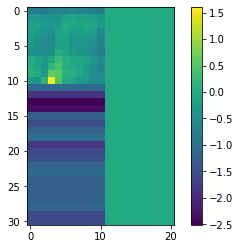

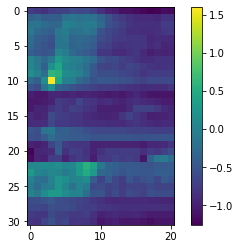

In [26]:
plt.figure()
plt.imshow(x_train_missingD[0,:,:])
plt.colorbar()
plt.figure()
plt.imshow(x_trainD[0,:,:])
plt.colorbar()

In [2]:
import statsmodels

In [10]:
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages

base = importr('base')
utils = importr('utils')
utils.chooseCRANmirror(ind=1)
utils.install_packages('POT') #installing POT package

R[write to console]: Installing package into ‘/home/VM-Nicolas-Lafon/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/POT_1.1-7.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 1028906 bytes (1004 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R

<rpy2.rinterface_lib.sexp.NULLType object at 0x7f88901bfbc0> [RTYPES.NILSXP]

In [13]:
from thresholdmodeling import thresh_modeling as t#importing package

In [91]:
i=0
x=dataset[:,i]
s = seuil_10[i]
print(s)
ksi=t.gpdfit(x,2220,'mle')
print(ksi[0])
    

2220.0
Estimator: MLE 
 Deviance: 26419.25 
      AIC: 26423.25 

Varying Threshold: FALSE 

  Threshold Call: 2220L 
    Number Above: 1806 
Proportion Above: 0.099 

Estimates
    scale      shape  
519.76173    0.06087  

Standard Error Type: observed 

Standard Errors
   scale     shape  
18.07857   0.02565  

Asymptotic Variance Covariance
       scale       shape     
scale  326.834654   -0.323444
shape   -0.323444    0.000658

Optimization Information
  Convergence: successful 
  Function Evaluations: 47 
  Gradient Evaluations: 21 


0.06087419450403571


<table>
<caption style="caption-side:bottom">Paramètre de forme par station</caption>
<tr>
<th>Station</th>
<th>1</th>
<th>2</th>
<th>3</th>
<th>4</th>
<th>5</th>
<th>6</th>
<th>7</th>
<th>8</th>
<th>9</th>
<th>10</th>
<th>11</th>
<th>12</th>
<th>13</th>
<th>14</th>
<th>15</th>
<th>16</th>
<th>17</th>
<th>18</th>
<th>19</th>
<th>20</th>
<th>21</th>
<th>22</th>
<th>23</th>
<th>24</th>
<th>25</th>
<th>26</th>
<th>27</th>
<th>28</th>
<th>29</th>
<th>30</th>
<th>31</th>
</tr>
<tr>
<th>Shape</th>
<th>0.061</th>
<th>0.052</th>
<th>0.083</th>
<th>0.073</th>
<th>0.062</th>
<th>0.092</th>
<th>0.086</th>
<th>0.055</th>
<th>0.052</th>
<th>0.050</th>
<th>0.20</th>
<th>0.15</th>
<th>0.15</th>
<th>0.18</th>
<th>0.22</th>
<th>0.21</th>
<th>0.24</th>
<th>0.28</th>
<th>0.29</th>
<th>0.34</th>
<th>0.23</th>
<th>0.21</th>
<th>0.14</th>
<th>0.14</th>
<th>0.25</th>
<th>0.26</th>
<th>0.28</th>
<th>0.22</th>
<th>0.24</th>
<th>0.18</th>
<th>0.18</th>
</tr>
<tr>
<th>Standard Error</th>
<th>0.035</th>
<th>0.027</th>
<th>0.028</th>
<th>0.027</th>
<th>0.026</th>
<th>0.027</th>
<th>0.026</th>
<th>0.027</th>
<th>0.026</th>
<th>0.026</th>
<th>0.028</th>
<th>0.024</th>
<th>0.027</th>
<th>0.027</th>
<th>0.027</th>
<th>0.028</th>
<th>0.030</th>
<th>0.032</th>
<th>0.030</th>
<th>0.032</th>
<th>0.028</th>
<th>0.028</th>
<th>0.027</th>
<th>0.026</th>
<th>0.032</th>
<th>0.031</th>
<th>0.031</th>
<th>0.028</th>
<th>0.028</th>
<th>0.027</th>
<th>0.027</th>
</tr>
</table>